# 1.) Load Data and Modules

In [1]:
# show graphs inline
%matplotlib inline

import pylab
import numpy as np
import pandas as pd
import seaborn as sns # high level, attractive data visualisation based on matplotlib
from scipy import stats
import matplotlib.pyplot as plt

train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2.) First Exploration

Analyse the data's type, shape and content:

* **PassengerId:** simple index from 1 to n passengers.
* **Survived:** 0 = died, 1 = survived.
* **Pclass:** 1 = 1st class, 2 = 2nd class, 3 = 3rd class (based on ticket purchased), a proxy for social class. This is an ordinal variable.
* **Name:** First, last and title (e.g. Mr, Mrs...). Titles give some indication as to age (e.g. Mr older than Master) and sirnames can indicate relation. Variable length string.
* **Sex:** basic male/female, a categorical string variable (NOTE: some 'Dr' can be women as well as men).
* **Age:** integer age of passengers, there are NaN values present.
* **SibSp:** number of siblings/spouses on board (ignoring mistresses and fiances). Ordinal variable.
* **Parch:** number of parents/children on board (some children came with relatives, therefore Parch=0). Ordinal variable.
* **Ticket:** ticket number as variable length string.
* **Fare:** price of ticket as float.
* **Cabin:** cabin number as variable string, there are Nan values present.
* **Embarked:** port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton), a categorical variable.

In [46]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* There is a sample of 891 in the train data with just over 1/3 surviving.
* There are more lower class people present (Pclass mean = 2.31).
* Average age is ~30 and most people are not accompanied by relatives or partners.
* The average fare is much lower than the most expensive, suggesting outliers and a drastic difference in ticket price.

### *Missing Values*

In [47]:
print(train.isnull().sum())
print(test.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


Train data contains lots of nulls for cabin number, a decent amount of nulls for age and a couple for embarkation port. The test data also contains a lot of nulls for cabin number and a similar proportion of missing ages, there is also a single missing fare. Nulls can significantly affect prediction models, breaking them altogether in some cases, so this information is useful to bear in mind.

In [48]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col="blue"
nosurv_col="red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      % (len(surv), (1.*len(surv)/len(train)*100.0), len(nosurv), (1.*len(nosurv)/len(train)*100.0), len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


The survival rate is just over 60% for the train sample, therefore by assuming that everyone in the test sample survived we would achieve an accuracy of 60%, but we will try to do better than this via a prediction model.

It's now time to plot the individual variables to understand their distribution and contents, I will use box plots displaying standard deviation to give a general overview of each variable along with its significance/dispersion. I have assigned blue and red as identifying colours for survived and not survived respectively going forward.

Median age survivors: 28.0, Median age non-survivers: 28.0


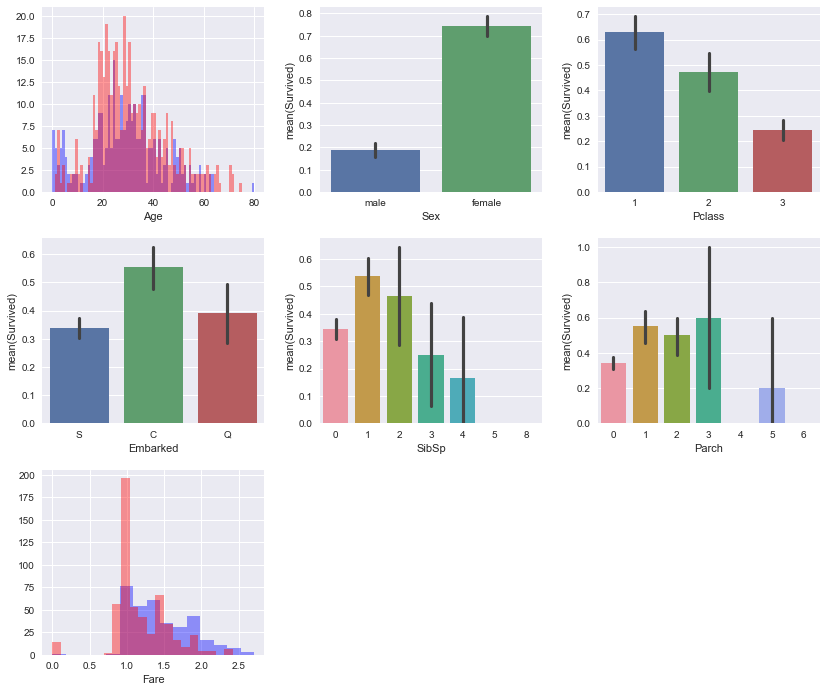

In [49]:
plt.figure(figsize=[12,10]) # create instance of a figure/graph with size

# 1) Age: ignoring nulls, scaled to max age, no gaussian estimate, coloured to surv/nosurv
plt.subplot(331) # 3x3 grid for first subplot (top left)
sns.distplot(surv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=nosurv_col, axlabel='Age')

# 2) Barplots (plot variable (x) against survival (y) from train data)
# Sex
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
# Pclass
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
# Embarked
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
# SibSp
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
# Parch
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)

# 3) Fare: ignoring nulls, no gaussian estimate, coloured to surv/nosurv
plt.subplot(337)
# log10 is used to prevent the high outliers from skewing data, +1 enables log graph to use integers
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col, axlabel='Fare')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=1, hspace=0.25, wspace=0.25) # space subplots

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
     %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

plt.show()

* The majority of passengers are around 30 and the medians are identical for survivors and non-survivors, however fewer young adults survived whilst young children were more likely to survive. There doesn't appear to be many teenagers, this is not an issue necessarily.
* Far more women survived than men.
* There is a correlation between class and survival where higher classes were more likely to survive.
* There is some difference between embarkation port and survival (C > Q > S), more information is needed to understand this pattern.
* There is a better survival rate for those with 1-3 siblings and/or children.
* Most fares are below 75 with most survivors having paid more on average for their tickets. There are some outliers which cost almost 200 which were paid by non-survivors. The survival rate for higher fares is much better than lower fares.

The standard deviation of SibSp is large and overlapping therefore the relationships aren't clear, because there are only 2 random possibilities (survived or not) for this variable we can use a binomial test to estimate the probability that 5 non-survivors from a sample of 5 passengers with 5 SibSp survived or not given the standard 38% chance of survival for the total sample.

In [50]:
stats.binom_test(x=5,n=5,p=0.62)

0.16417601599999998

For the result of a binomial test to be significant it normally has to be within 5% (0.05), because this is higher we cannot say for certain that having 5 siblings makes you less likely to survive.

We learn that *parch >= 4 and sibsp >= 3 is bad*, so is *parch + sibsp = 0* but *parch = 1:3 and sibsp = 1:2* is good.

### *Cabin numbers*

There are many NaN values in the cabin numbers, so they may be a tricky one to look at.

In [51]:
print("%i of %i cabin numbers known in train data." % (len(train['Cabin'].dropna()), len(train)))
print("%i of %i cabin numbers known in test data." % (len(test['Cabin'].dropna()), len(test)))

train.loc[:,['Survived','Cabin']].dropna().head(8) # show top 8 rows of training data for cabin number and survival

204 of 891 cabin numbers known in train data.
91 of 418 cabin numbers known in test data.


,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27


* We are missing many of the cabin numbers, this means that it will be a tricky variable to use but also that they didn't record this information well.
* Perhaps they mostly recovered the cabin numbers from survivors, this is worth investigating via derived features (later).

### *Ticket numbers*

At first glance these are all random, variable length strings with no connection. However, it may be that families or groups shared ticket numbers.

In [52]:
print("%i unique tickets amongst %i total tickets." % (train['Ticket'].nunique(), train['Ticket'].count()))

681 unique tickets amongst 891 total tickets.


There are fewer unique tickets than total tickets therefore some ticket numbers must be shared, let's look at these by grouping people with shared tickets.

In [53]:
grouped = train.groupby('Ticket') # group df rows by column and return series
count = 0
for ticket_name, group_info in grouped:
    if(len(group_info) > 1):
        count += 1
        print(group_info.loc[:,['Survived','Name']])
    if(count > 5):
        break

     Survived                                               Name
257         1                               Cherry, Miss. Gladys
504         1                              Maioni, Miss. Roberta
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...
     Survived                                    Name
262         0                       Taussig, Mr. Emil
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)
585         1                     Taussig, Miss. Ruth
     Survived                            Name
110         0  Porter, Mr. Walter Chamberlain
475         0     Clifford, Mr. George Quincy
     Survived                                             Name
329         1                     Hippach, Miss. Jean Gertrude
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)
     Survived                                    Name
166         1  Chibnall, Mrs. (Edith Martha Bowerman)
356         1             Bowerman, Miss. Elsie Edith
     Survived                      

It looks like a general pattern is people in shared ticket groups survive except for the lead male who potentially helps them off and stays behind. Looking for people grouped by family name actually doesn't look like a great predictor though because not all groups are families and family names might not be unique on the ship, therefore using a shared ticket as a predictor would be the best bet.

# 3.) Relations between features

Looking at the variables individually has been useful, now we will look at their relationships with each other. Does age-dependent survival change with age? Are Pclass and fare incredibly tightly linked? If so, can one be left out as a predictor if it simply mimics the other?

I will create an overview plot of the numerical variables (ignoring ID which provides no useful info) where red and blue show positive and negative correlation respectively, the closer they are to white the less correlated they are.

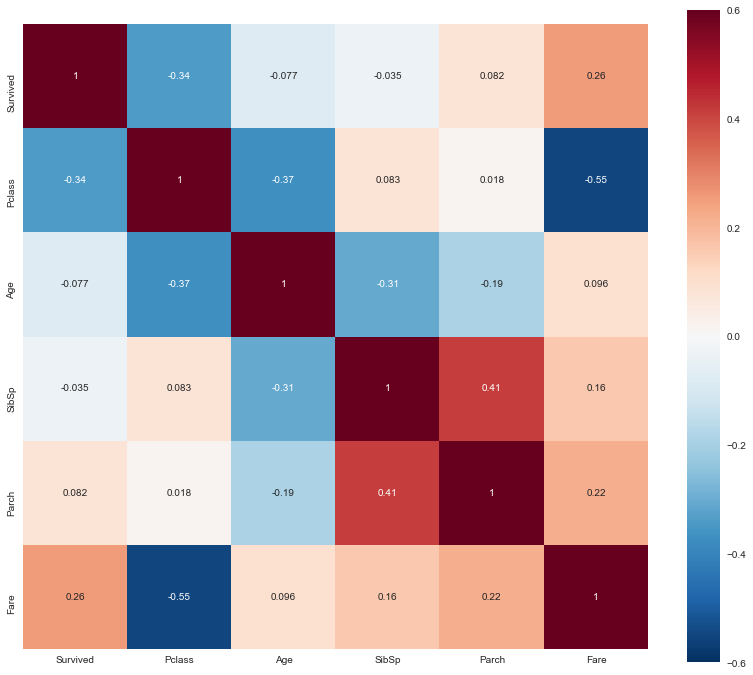

In [54]:
plt.figure(figsize=(14,12))
overview = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)
plt.show()

We are looking for strongly correlated variables, whether positive (one increases with the other) or weakly (one increases as the other decreases). Key inferences we can make here are:

* Pclass and Fare are somewhat negatively correlated (higher classes buy more expensive tickets).
* SibSp and Parch are somewhat positively correlated (people with large families are likely to include siblings, spouses, parents and children).
* Pclass and survival is negatively correlated (higher classes are more likely to surive).

I will also use a pairplot to examine the relationship between individual variables more closely, this is best use for continuous data rather than the categorical variables we mostly have, however it still provides some useful information and also shows the distribution of each individual variable by itself.

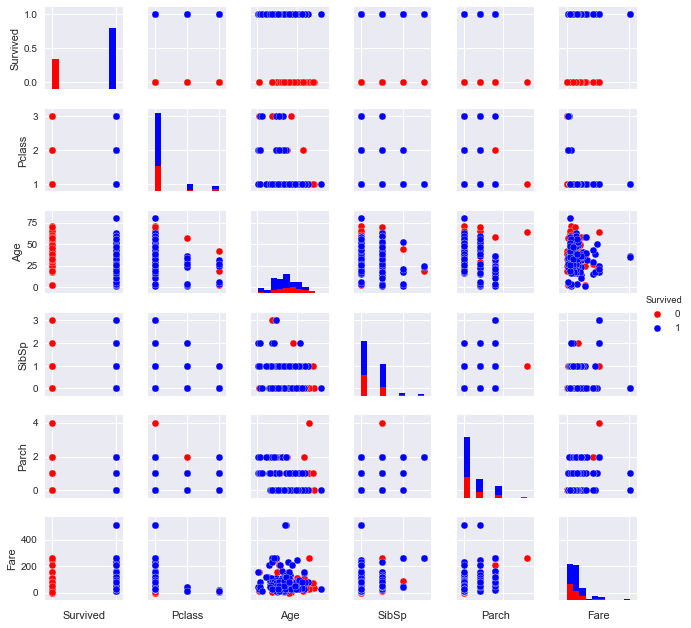

In [63]:
cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
plt = sns.pairplot(data=train.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])
plt.set(xticklabels=[])
#sns.plt.show()

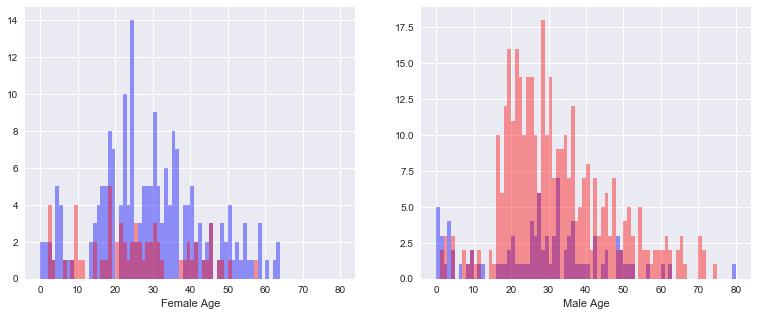

In [69]:
msurv = train[(train['Survived']==1)&(train['Sex']=="male")]
fsurv = train[(train['Survived']==1)&(train['Sex']=="female")]
mnosurv = train[(train['Survived']==0)&(train['Sex']=="male")]
fnosurv = train[(train['Survived']==0)&(train['Sex']=="female")]

plt.figure(figsize=[13,5])
plt.subplot(121)
sns.distplot(fsurv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=surv_col)
sns.distplot(fnosurv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=nosurv_col, axlabel='Female Age')
plt.subplot(122)
sns.distplot(msurv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=surv_col)
sns.distplot(mnosurv['Age'].dropna().values, bins=range(0,81,1), kde=False, color=nosurv_col, axlabel='Male Age')

* Female survival rate between 18 and 40 looks significantly higher than other ages, male surival rate is the opposite with 18-40 year olds being more likely to die.
* Boys have a higher surival rate than men, whereas girls and women are similarly likely to survive. However, for all of this information the counts are fairly low,particularly outside of the 18-40 range.

Now let's look at the correlation between Age and Pclass with a violin plot which splits survived and not survived to the right and left respectively.

In [3]:
foo = combine['Age'].hist(by=combine['Pclass'], bins=np.arange(0,81,1), layout=[3,1], sharex=True, figsize=[8,12])
foo = sns.boxplot(x="Pclass", y="Age", hue="Survived", data=train)
sns.violinplot(x="Pclass", y="Age", data=combine, inner=None)
sns.swarmplot(x="Pclass", y="Age", data=combine, color="w", alpha=.5)

#sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train, split=True)
#plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

NameError: name 'combine' is not defined

# LINKS:
https://www.kaggle.com/headsortails/pytanic
https://www.kaggle.com/c/titanic/data
https://www.analyticsvidhya.com/blog/2014/11/data-science-projects-learn/
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/
https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
https://matplotlib.org/users/pyplot_tutorial.html
https://www.analyticsvidhya.com/blog/2014/09/data-munging-python-using-pandas-baby-steps-python/
https://www.kaggle.com/c/titanic#tutorials

## To Do:
* Check and handle missing values/NaNs.
* Create derived features to analyse cabin numbers link to survival.
* Check for outliers, if present consider methods of handling them.
* Look at categorical values and consider converting to binary/ranked.
* Consider creating additional features to enhance prediction modelling.
* Consider prediction models to use, compare different methods (normalising/scaling data as appropriate).
* Visualise outputs and choose best model.
* Optimise selected model and show evidence of how I produced the final configuration.